In [366]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Data

In [5]:
# data = pd.read_csv("/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/WineData/cleansingWine.csv", low_memory=False)
data = pd.read_csv("/Users/Bnkes/Desktop/GitHub/AdvancedMachineLearning/Data/WineData/cleansingWine.csv", low_memory=False)
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,id,name,producer,nation,local1,local2,local3,local4,varieties1,varieties2,...,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,137197,Altair,Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Carmenere,...,Table,14~15,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,137198,"Altair, Sideral",Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Merlot,...,Table,14~15,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,137199,Baron du Val Red,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Cinsault,...,Table,11~12,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,137200,Baron du Val White,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Ugni​ blanc,...,Table,11~12,9~11,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,137201,"Benziger, Cabernet Sauvignon",Benziger,USA,California,NaN,NaN,NaN,Cabernet Sauvignon,NaN,...,Table,13~14,17~19,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750


In [7]:
def remove_tilda(value):
    if "~" in value:
        values = value.split("~")
        avg = (float(value[0]) + float(value[-1]))/2
        return avg
    else:
        return float(value)

In [9]:
clean_data = data.drop(
    ["id", "name", "producer", "local3", "local4", "varieties2",
     "varieties3", "varieties4", "varieties5", "varieties6", "varieties7",
     "varieties8", "varieties9", "varieties10", "varieties11", "varieties12"], axis = 1)
clean_data = clean_data[(clean_data["price"] != 0) & (clean_data["year"] != 0)]
clean_data = clean_data.dropna(axis = 0)
clean_data["year"] = clean_data["year"].astype(str)
clean_data["abv"] = clean_data["abv"].apply(lambda x: remove_tilda(x))
clean_data["degree"] = clean_data["degree"].apply(lambda x: remove_tilda(x))
clean_data.reset_index(inplace=True, drop=True)
clean_data

,nation,local1,local2,varieties1,type,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,France,Southern France,Languedoc Roussillon,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY2,TANNIN3,19000,2017,750
1,France,Southern France,Languedoc Roussillon,Merlot,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,19000,2011,750
2,France,Bordeaux,Premieres Cotes de Bordeaux,Semillon,White,Dessert,13.0,1.5,SWEET2,ACIDITY4,BODY3,TANNIN1,18000,2009,750
3,France,Bordeaux,Medoc,Cabernet Sauvignon,Red,Table,2.0,4.5,SWEET1,ACIDITY4,BODY3,TANNIN3,32000,2015,750
4,France,Bordeaux,SaintEmilion,Merlot,Red,Table,2.0,4.5,SWEET1,ACIDITY3,BODY2,TANNIN2,42000,2010,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,Italy,Toscana,Bolgheri,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,250000,2007,750
4017,USA,California,Riverside County,Sangiovese,Rose,"Appetizer, Table",2.5,4.0,SWEET2,ACIDITY3,BODY2,TANNIN1,195000,2013,750
4018,USA,California,Napa County,Cabernet Sauvignon,Red,Table,3.0,4.5,SWEET1,ACIDITY3,BODY4,TANNIN4,475000,2006,750
4019,the Republic of South Africa,Coastal Region,Paarl,Chardonnay,White,"Appetizer, Table",2.0,1.5,SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


In [11]:
ct = ColumnTransformer(
    [
        ("dummify", preprocessing.OneHotEncoder(sparse_output=False, handle_unknown="error", drop = "first"), make_column_selector(dtype_include=object)),
        ("standardize", preprocessing.StandardScaler(), make_column_selector(dtype_include=np.number))
    ], remainder = "passthrough"
)

## Neural Networks

### Regression Model

In [13]:
X = clean_data.drop("price", axis = 1)
X = ct.fit_transform(X)
y = clean_data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=1)

In [159]:
#construct the model
inputs = keras.Input(shape=(453,))
x = layers.Dense(400, activation = 'relu')(inputs)
x = layers.Dropout(rate=.1)(x)
x = layers.Dense(200, activation = "relu")(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(100, activation = "relu")(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="wine_model")

In [177]:
model.summary()

Model: "wine_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 438)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 400)                 │         175,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 200)                 │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,941 (1.06 MB)

 Trainable params: 277,941 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

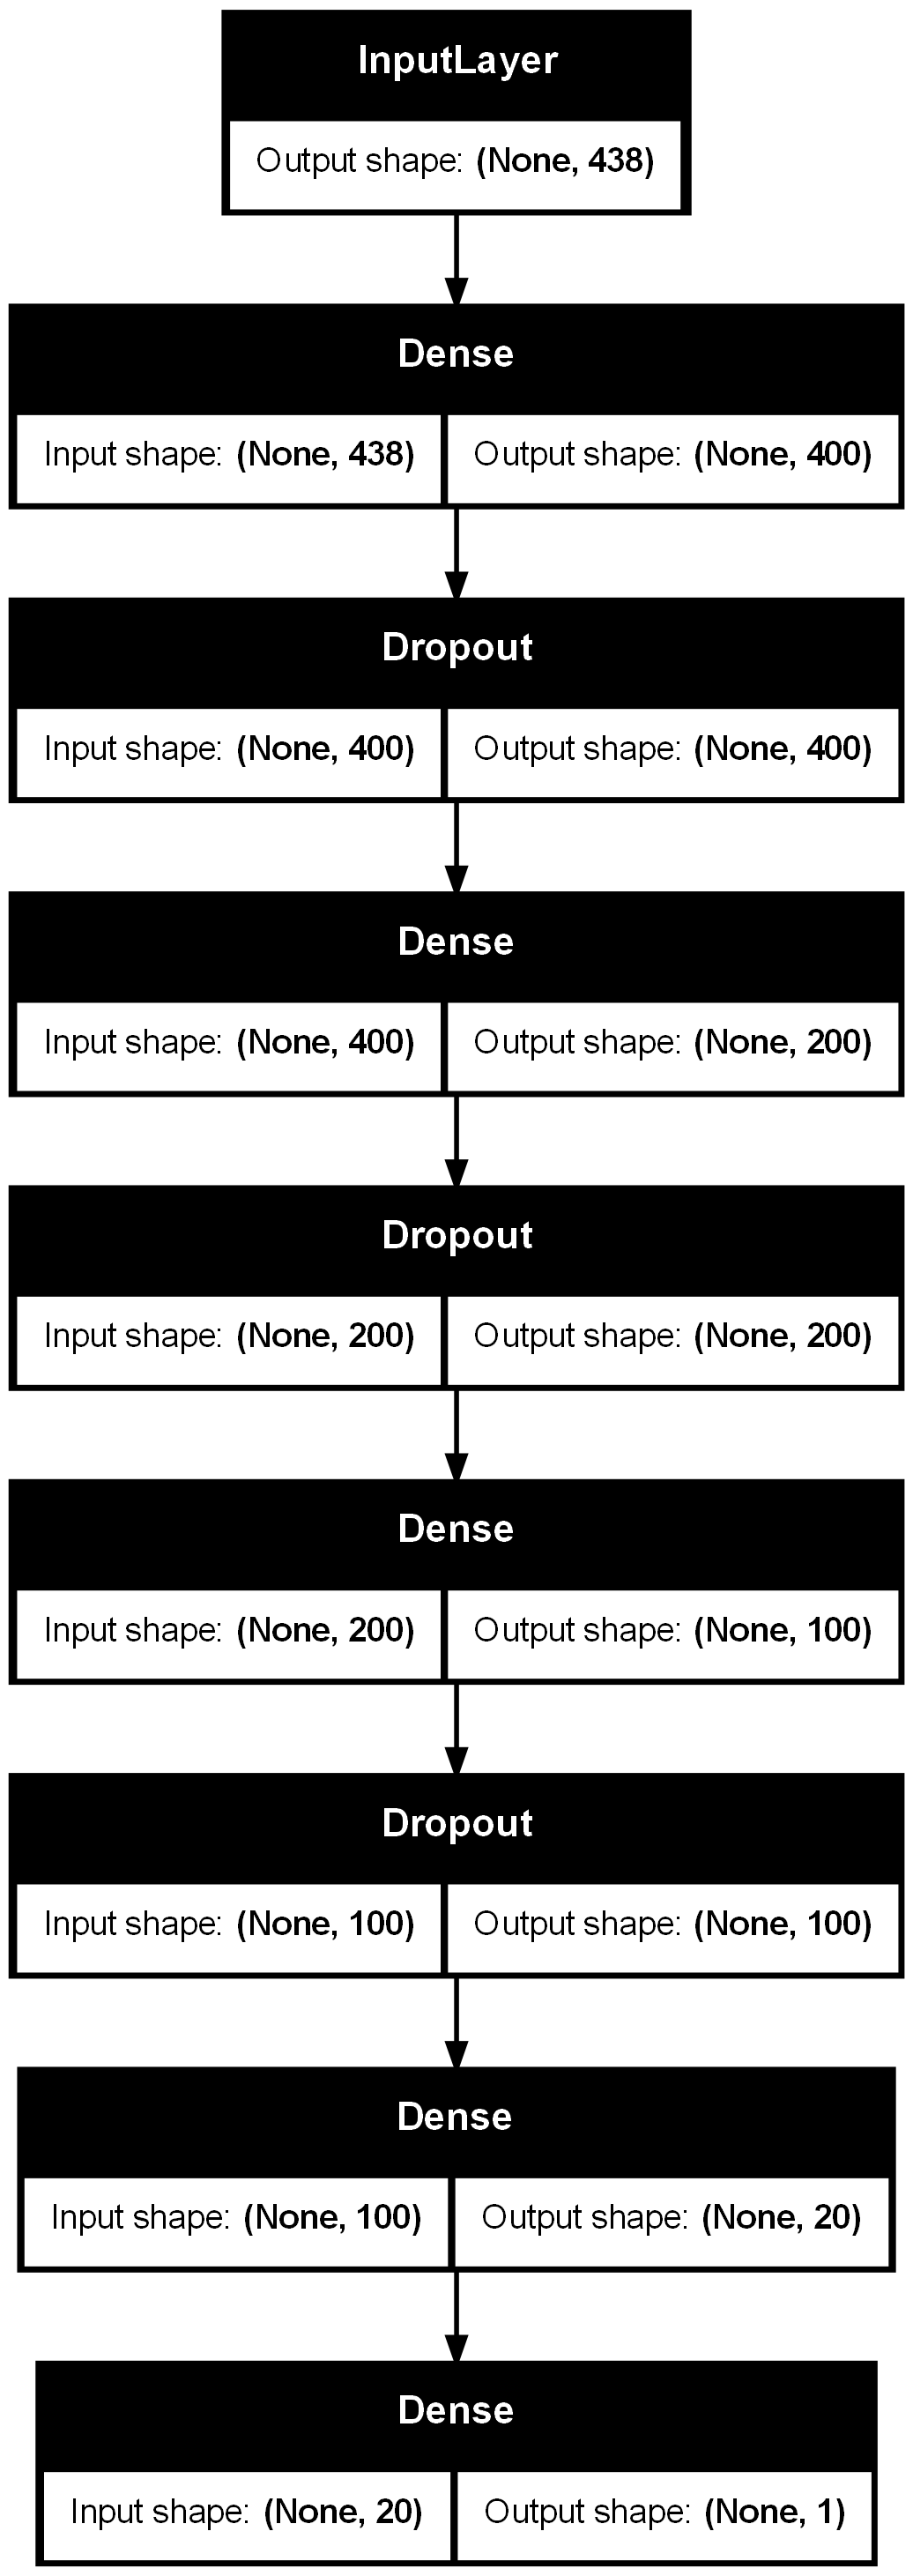

In [179]:
keras.utils.plot_model(model, show_shapes = True)

In [161]:
model.compile(
    loss = keras.losses.Huber(delta=1.0),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.R2Score],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=100, validation_split=.2)

scores = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 188581.8906 - r2_score: -0.5798 - val_loss: 156182.8438 - val_r2_score: -0.7862
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 192530.2188 - r2_score: -0.3951 - val_loss: 155310.9375 - val_r2_score: -0.7772
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 184739.6719 - r2_score: -0.4435 - val_loss: 152595.8438 - val_r2_score: -0.7496
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 186106.2188 - r2_score: -0.4420 - val_loss: 146817.2656 - val_r2_score: -0.6923
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 183446.7812 - r2_score: -0.4074 - val_loss: 136632.5781 - val_r2_score: -0.5964
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 156031.8438 - r2_score: -0.4211 - val_loss: 121812.7578 - val_r2_score: -0.4604
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160038.6719 - r2_score: -0.3023 - val_loss: 108553.2812 - val_r2_score: -0.3183
Epoch 8/100
13/13 ━━━━━━━━

### Classification Model

In [368]:
X = clean_data.drop(["nation", "local1", "local2"], axis = 1)
X = ct.fit_transform(X)
y = clean_data["nation"]
y = preprocessing.LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=1)

In [378]:
#construct the model
inputs = keras.Input(shape=(172,))
x = layers.Dense(150, activation = 'relu')(inputs)
x = layers.Dropout(rate=.1)(x) # Try to avoid overfitting with dropout layers
x = layers.Dense(100, activation = "relu")(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(50, activation = "relu")(x)
x = layers.Dropout(rate = .1)(x)
outputs = layers.Dense(17, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="nation_model")

In [380]:
model.summary()

Model: "nation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 172)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 150)                 │          25,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 17)                  │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,967 (183.46 KB)

 Trainable params: 46,967 (183.46 KB)

 Non-trainable params: 0 (0.00 B)

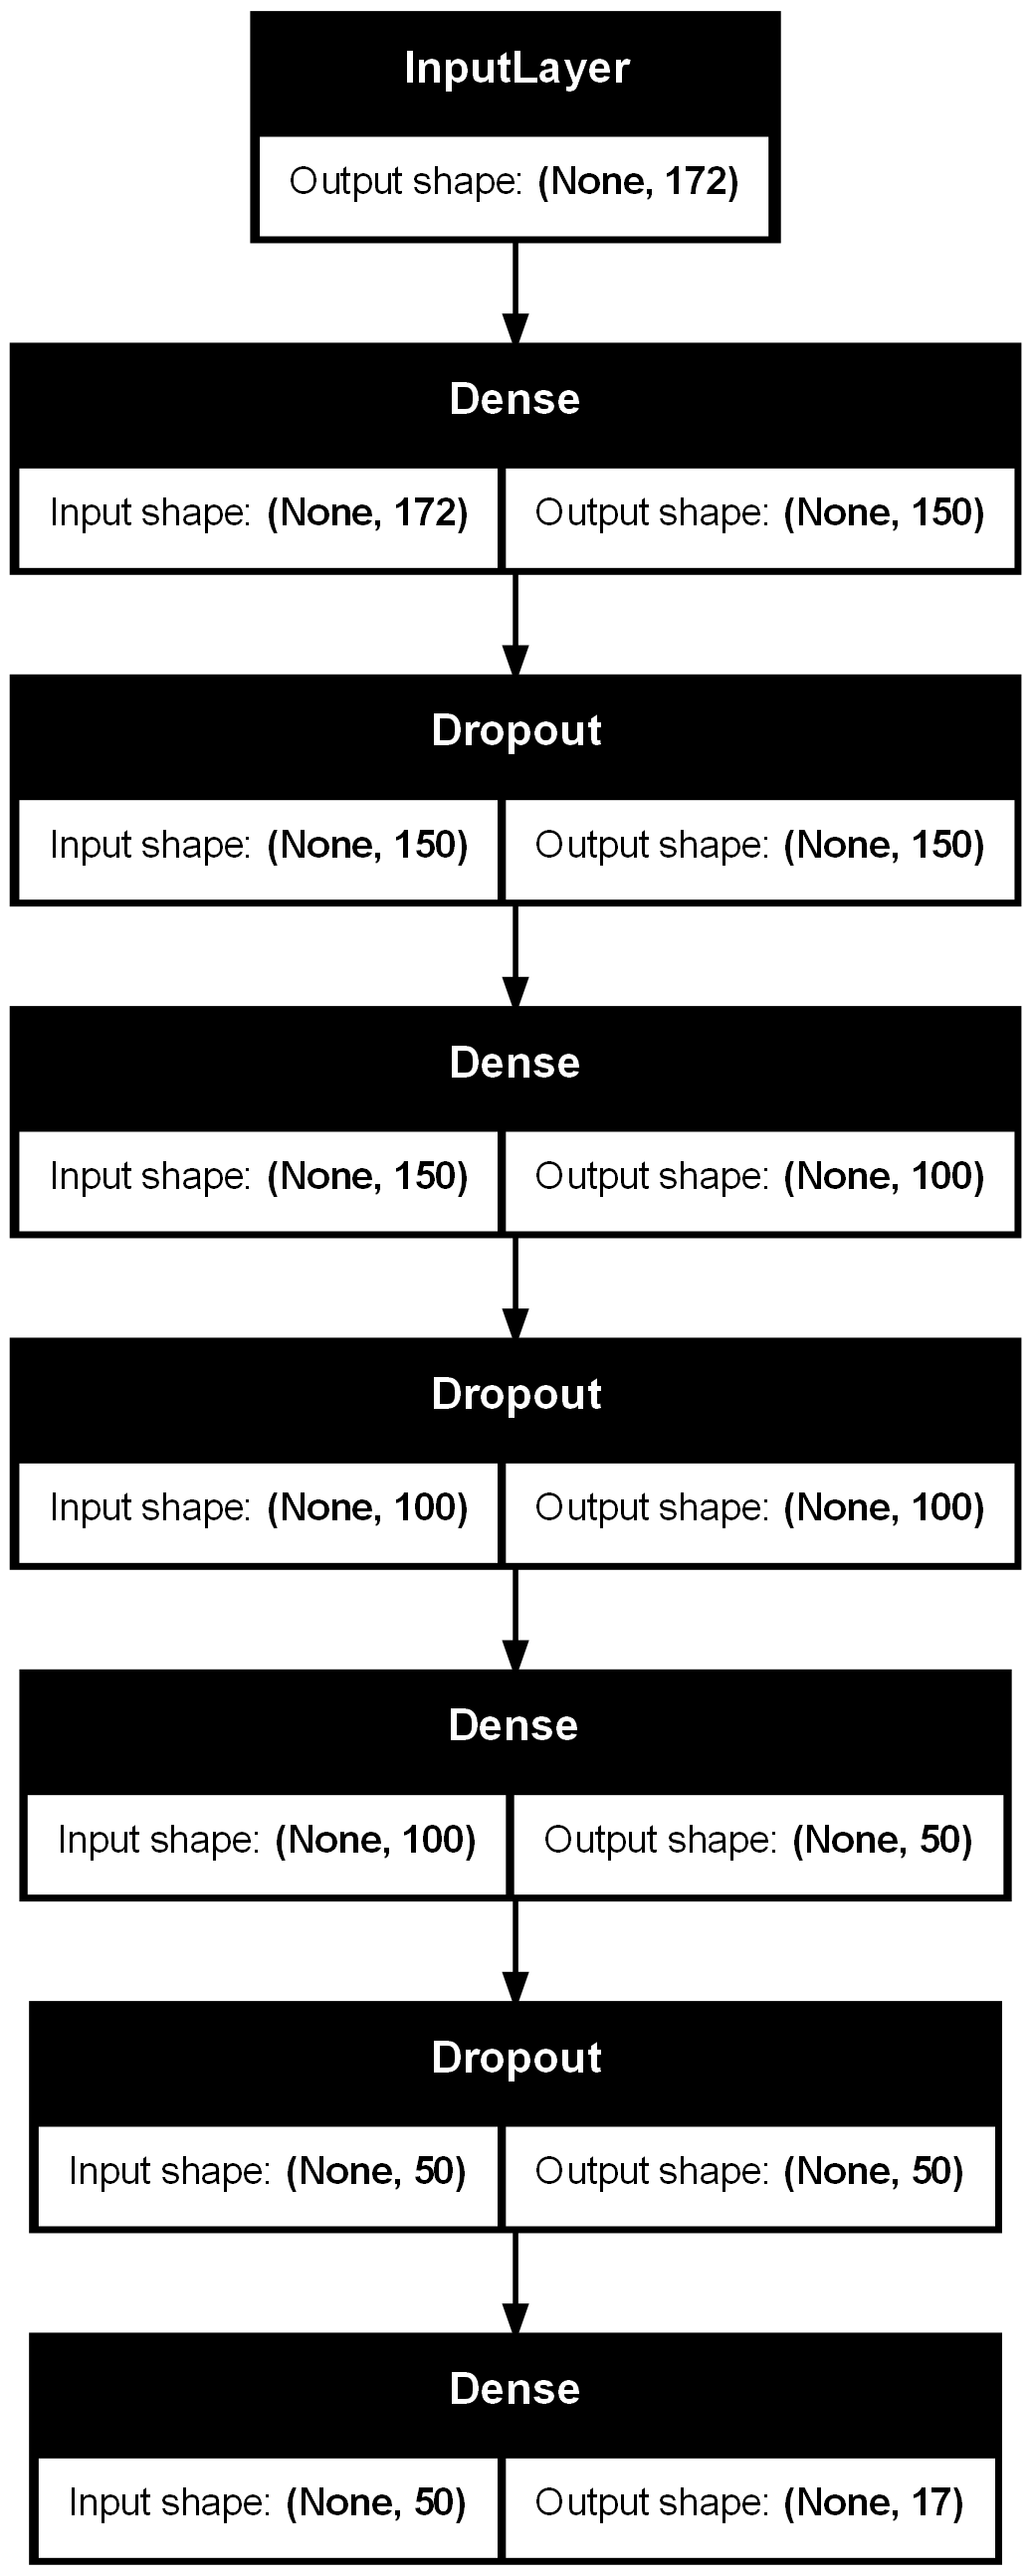

In [382]:
keras.utils.plot_model(model, show_shapes = True)

In [386]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=50, validation_split=.2)

scores = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8112 - sparse_categorical_accuracy: 0.7058 - val_loss: 1.3260 - val_sparse_categorical_accuracy: 0.5821
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.7592 - val_loss: 1.3075 - val_sparse_categorical_accuracy: 0.5821
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6976 - sparse_categorical_accuracy: 0.7495 - val_loss: 1.3276 - val_sparse_categorical_accuracy: 0.5871
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6668 - sparse_categorical_accuracy: 0.7675 - val_loss: 1.3616 - val_sparse_categorical_accuracy: 0.5821
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.7692 - val_loss: 1.3731 - val_sparse_categorical_accuracy: 0.5622
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6830 - sparse_categorical_accuracy: 0.7707 - val_loss: 1.3345 - val_sparse_categorical_accuracy: 0.5821
Epoch 7/50
13/13

In [388]:
y_pred_prob = model.predict(X_test)  # Get predicted probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


In [390]:
nation_labels = clean_data["nation"].to_list()
nation_dict = dict(zip(y, nation_labels))

pred_columns = [f"Predicted {nation_dict[i]}" for i in range(17)]
actual_columns = [f"Actual {nation_dict[i]}" for i in range(17)]

In [394]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=pred_columns, index = actual_columns)

,Predicted Argentina,Predicted Australia,Predicted Austria,Predicted Canada,Predicted Chile,Predicted France,Predicted Germany,Predicted Greece,Predicted Hungary,Predicted Italy,Predicted Japan,Predicted Korea,Predicted New Zealand,Predicted Portugal,Predicted Spain,Predicted USA,Predicted the Republic of South Africa
Actual Argentina,6,5,0,0,3,8,0,1,0,1,0,0,1,0,0,14,1
Actual Australia,0,94,0,1,16,100,0,0,0,6,0,0,2,0,0,53,2
Actual Austria,0,2,1,0,0,7,0,0,0,4,0,0,1,0,0,5,0
Actual Canada,0,1,0,2,1,3,0,0,0,4,0,0,1,0,0,3,0
Actual Chile,3,32,0,1,69,66,0,0,0,2,0,0,5,0,0,43,1
Actual France,2,67,0,0,53,734,0,1,0,32,0,0,13,0,0,134,9
Actual Germany,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Actual Greece,0,1,0,0,0,5,0,2,0,4,0,0,0,0,0,1,1
Actual Hungary,0,0,0,2,2,3,0,0,0,2,0,0,1,0,0,1,0
Actual Italy,0,7,0,0,11,31,0,0,0,477,0,0,3,0,0,20,0
